In [1]:
import math
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import random
import pandas as pd
import queue
import time
from sklearn.neighbors import KDTree
from scipy import spatial

# 1. K-Means++

In [2]:
#Load Data and create column names X, Y and the class variable as Label
data = pd.read_csv('https://raw.githubusercontent.com/atreish/AIM_5005_Machine_Learning/main/as3_1.txt', 
                   sep='\t', names=['X','Y','label'])
data.head(5)

,X,Y,label
0,25.0514,5.7475,1
1,26.6614,7.3414,1
2,25.2653,6.2466,1
3,25.2285,4.7447,1
4,25.7529,5.1564,1


In [3]:
#How many classes are there? Summary Statistics of our Data frame
classes = data.label.unique()
X_col = data.X.describe()
Y_col = data.Y.describe()

print('The Summary Statistics of X Column are:\n\n{}'.format(X_col))
print('\n\nThe Summary Statistics of Y Column are:\n\n{}'.format(Y_col))
print('\n\nVector of Unique Class Variables:\n\n{}'.format(classes))

The Summary Statistics of X Column are:

count    3100.000000
mean       16.739989
std         7.325422
min         2.907000
25%        10.442950
50%        16.483900
75%        23.394825
max        29.593900
Name: X, dtype: float64


The Summary Statistics of Y Column are:

count    3100.000000
mean       17.127637
std         6.750086
min         3.792500
25%        10.969075
50%        16.871450
75%        22.358100
max        29.853800
Name: Y, dtype: float64


Vector of Unique Class Variables:

[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31]


No handles with labels found to put in legend.


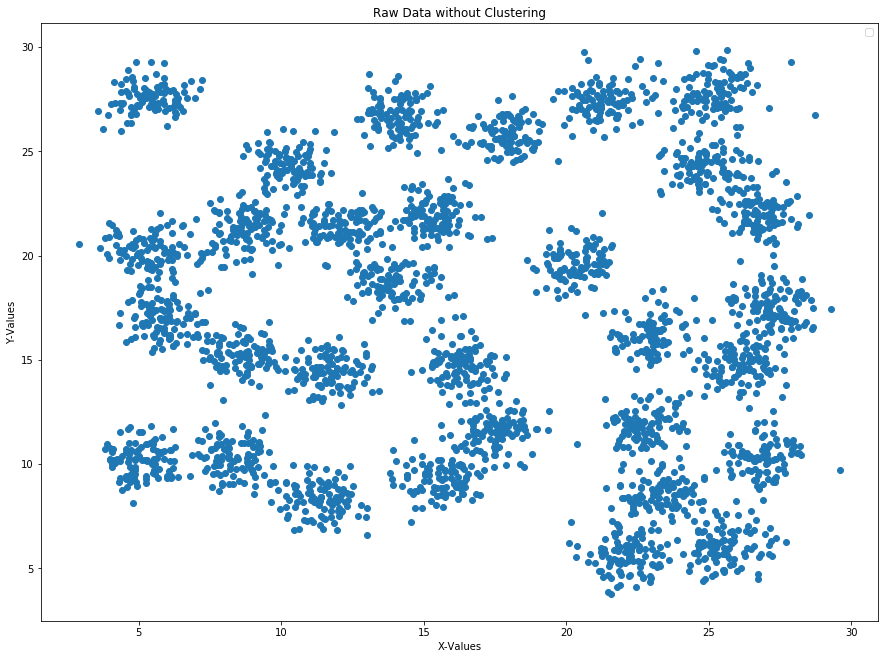

In [4]:
#Plot X,Y Data points

data1 = np.array(data.iloc[:,:-1]) #cast into an array for analysis and plotting, without Label 
plt.figure(figsize=(15,11))
plt.scatter(data1[:, 0], data1[:, 1]) #on our graph x-axis= 1st column of array, y-axis= 2nd column of array
plt.title('Raw Data without Clustering')
plt.xlabel('X-Values')
plt.ylabel('Y-Values')
plt.legend()
plt.show()

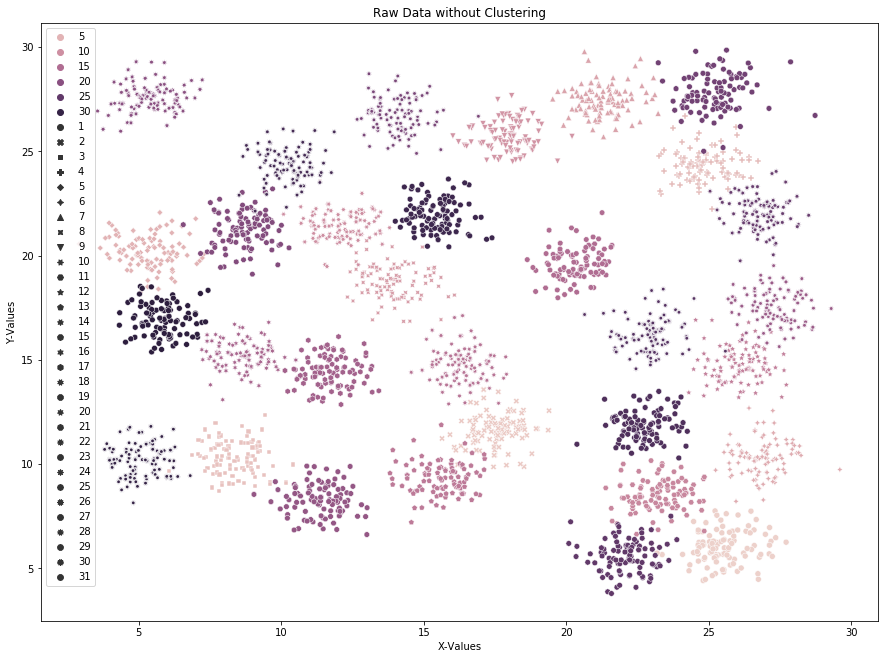

In [5]:
#Plot X,Y Data by Label using Seaborn hue

plt.figure(figsize=(15,11))
sns.scatterplot( data=data, x=data.X, y=data.Y, hue='label', style='label' ) 
plt.title('Raw Data without Clustering')
plt.xlabel('X-Values')
plt.ylabel('Y-Values')
plt.legend()
plt.show()

In [6]:
"""Create myInit() that places the initial k centroids far away from each other
in the 4 steps as shown below:
1. Randomly select the first centroid from the data points
2. For each data point compute its distance from the nearest, previously
chosen centroid
3. Select the point having maximum distance from the nearest centroid as
the next centroid
4. Repeat steps 2 and 3 until k centroids have been sampled
"""

def myInit(K):
    random.seed(1)
    i = random.randint(0, data1.shape[0])
    Centroids = np.array([data1[i]])
    for k in range(1,K):
        distance = np.array([]) 
        for i in data1:
            distance = np.append(distance, np.min(np.sqrt(np.sum((i-Centroids)**2, axis=1))))
        prob = distance / np.sum(distance)   
        cummulative_prob = np.cumsum(prob)        
        r = random.random()
        i = 0
        for index, pb in enumerate(cummulative_prob):
            if r < pb:
                i = index 
                break
        Centroids = np.append(Centroids,[data1[i]],axis=0)
    return Centroids.T

"""Create myAssign() that assigns each example to the nearest centroid, 𝜇(𝑗), 𝑗
∈ {1, ... , 𝑘} where for every x(i), label[x(i)]=J which is arg minj ||x(i)−𝜇(𝑗)||^2."""

def myAssign(near_dist):
    cluster_array = np.argmin(near_dist, axis=1)+1 
    min_dist = near_dist.min(axis=1) 
    return cluster_array, min_dist

"""Create myCentroid() that calculates a new centroid of all points that are
assigned to the same centroid."""

def myCentroid(K, Centroids):
    near_dist = np.array([]).reshape(data1.shape[0],0)
    for k in range(K):
        tempDist = np.sqrt(np.sum((data1 - Centroids[:,k])**2, axis=1))
        near_dist = np.c_[near_dist, tempDist]
    return near_dist

"""Create myUpdateCentroid() that moves the centroids to the center of the
examples that were assigned to it"""

def myUpdateCentroid(K, cluster_array, Centroids):
    new_Centroids = Centroids.copy()
    cluster = {}
    for k in range(K):
        cluster[k+1] = np.array([]).reshape(2,0)
    for i in range(data1.shape[0]):
        cluster[cluster_array[i]] = np.c_[cluster[cluster_array[i]], data1[i]]
    for k in range(K):
        cluster[k+1] = cluster[k+1].T
    for k in range(K):
        new_Centroids[:,k] = np.mean(cluster[k+1],axis=0)
    return cluster, new_Centroids

"""Create myPlot() that visualizes plot of clustering result in different colors and markers. 
You can use any plot method."""
    
def myPlot(K,cluster,Centroids,Init_Centroids):
    for k in range(K):
        plt.scatter(cluster[k+1][:,0],cluster[k+1][:,1])
    p1 = plt.scatter(Centroids[0,:],Centroids[1,:],s=100,c='black',label='Centroids')
    p2 = plt.scatter(Init_Centroids[0,:],Init_Centroids[1,:],s=100,c='r',label='Init_Centroids',marker='*')
    plt.title('The number of clusters is {}'.format(k+1))
    plt.xlabel('x')
    plt.ylabel('y')
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5)) # set the legend label out of graph
    plt.show()
    
"""Create myKmeanPlusPlus() that initially calls myInit(), and then
repeats to call myAssign(), myCentroid(), and myUpdateCentroids() until the cluster assignments do not change or a user-defined tolerance or maximum number of iteration is reached. myKmeanPlusPlus() should ask user to receive the following arguments and use the same variable name in the parenthesis:
1. The number of clusters (k)
2. Tolerance (myTol)
3. Maximum number of iterations (myMax)"""

def myKmeanPlusPlus(myk, myTol, myMax):
    Init_Centroids = myInit(K=myk)
    Centroids = Init_Centroids.copy()
    final_cluster = {}
    for i in range(myMax):
        euclidean_distance = myCentroid(myk, Centroids)
        cluster_array, min_dist = myAssign(euclidean_distance) 
        final_cluster, curr_Centroids = myUpdateCentroid(myk, cluster_array, Centroids)
        tol_condition = np.sum((curr_Centroids - Centroids)/Centroids * 100.0)
        if  tol_condition < myTol:
            break
        Centroids = curr_Centroids
    myPlot(myk,final_cluster,Centroids,Init_Centroids)
    cost = sum(min_dist)
    return cost

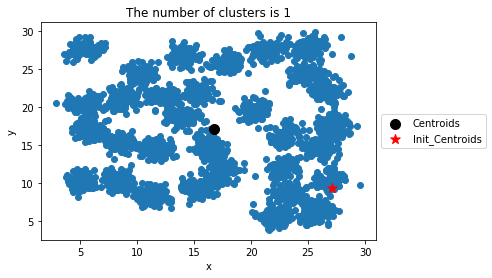

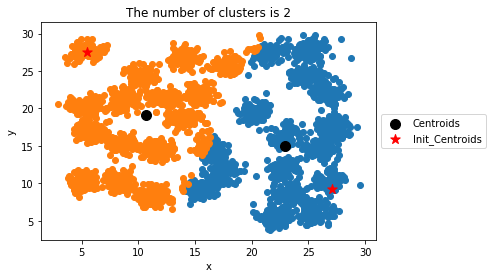

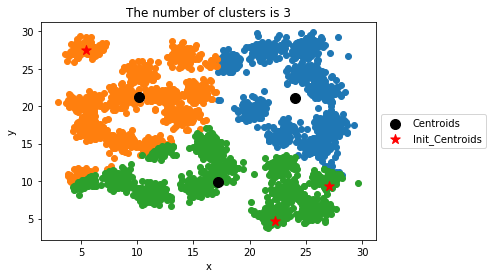

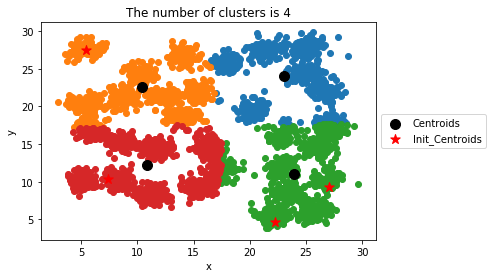

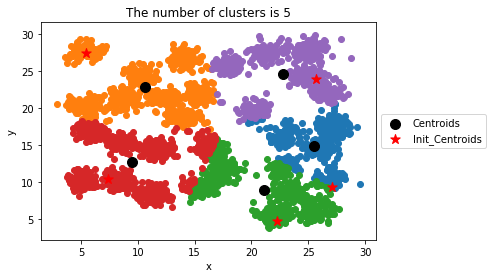

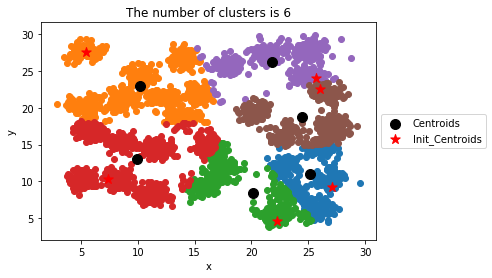

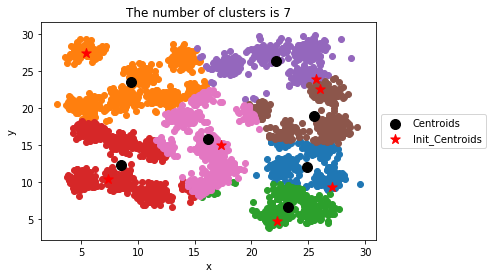

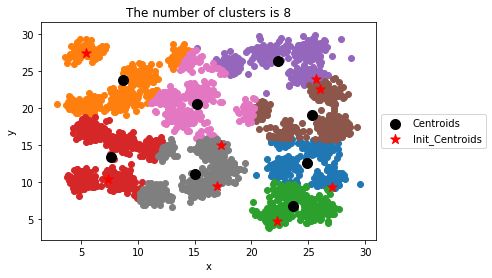

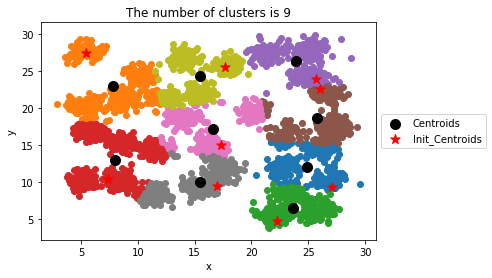

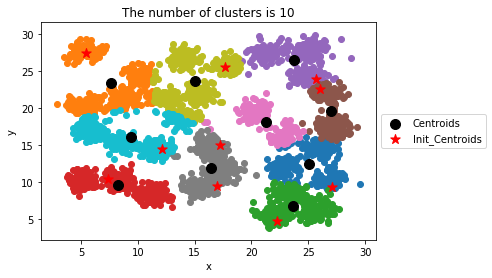

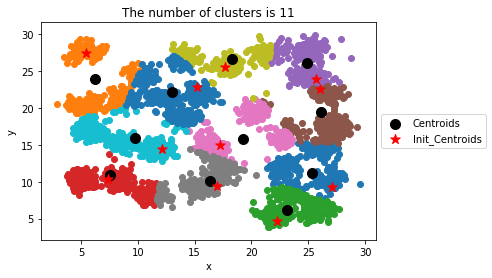

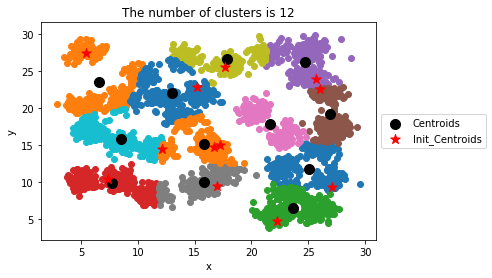

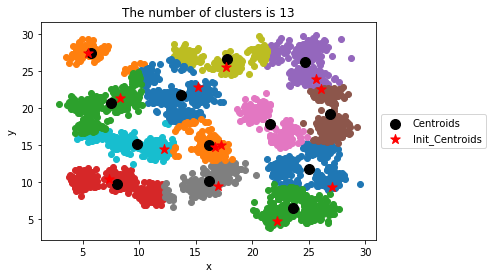

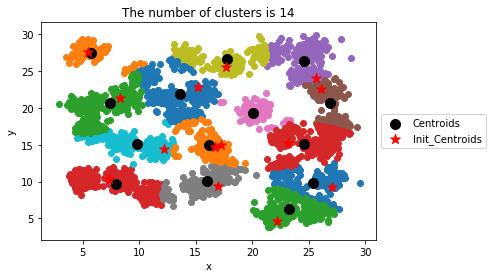

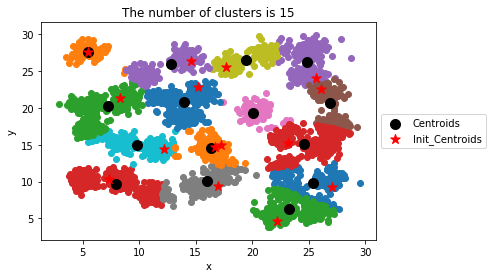

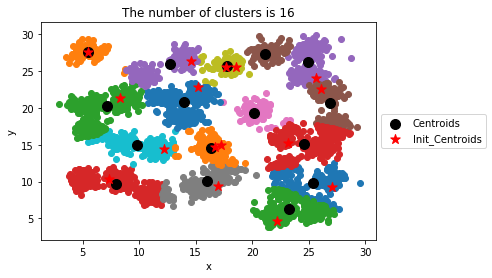

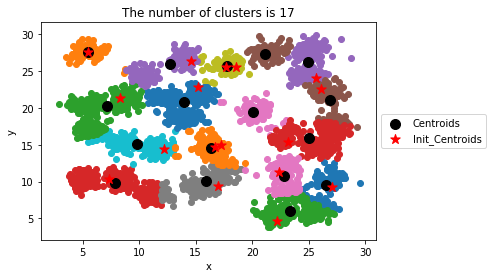

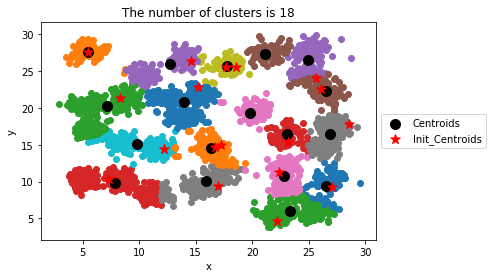

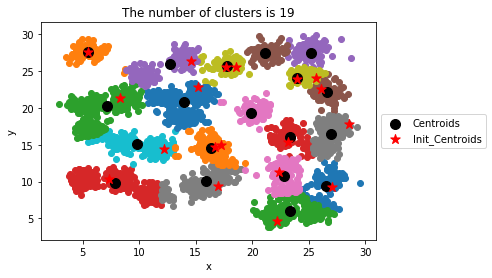

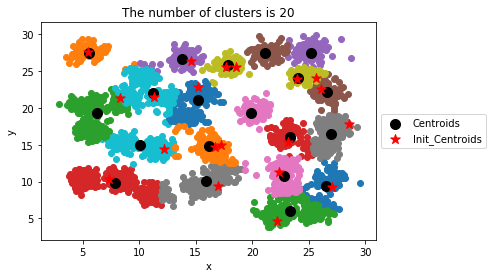

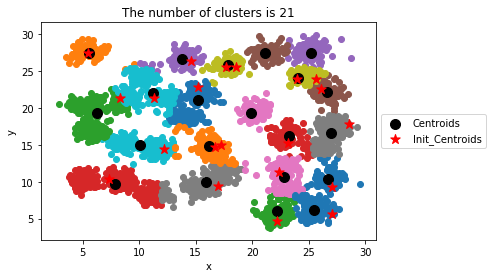

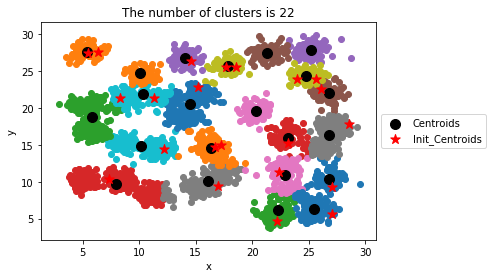

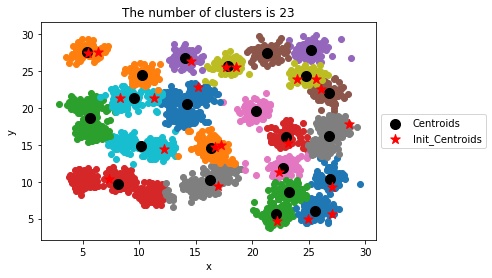

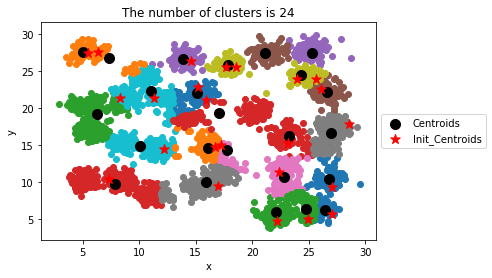

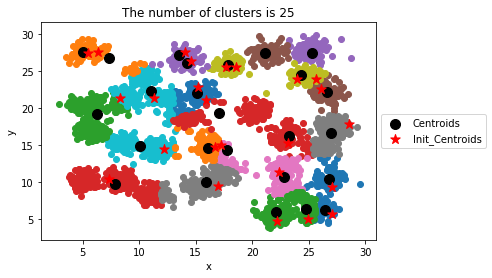

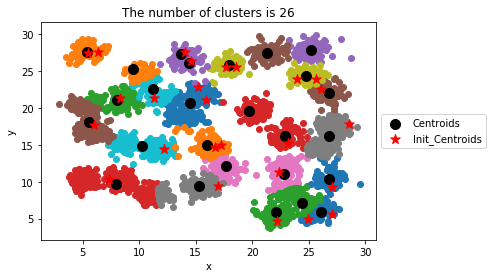

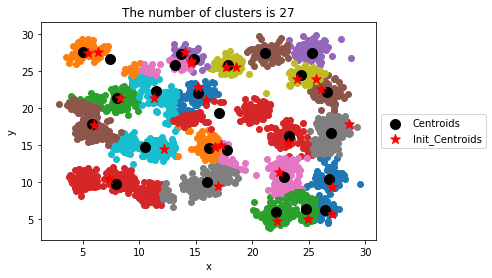

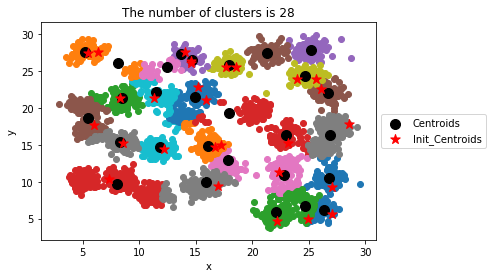

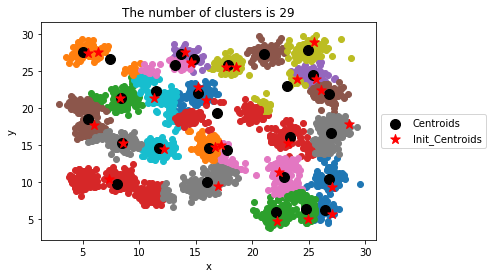

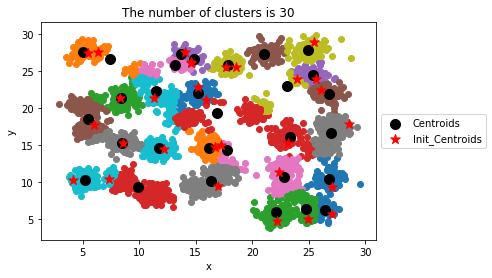

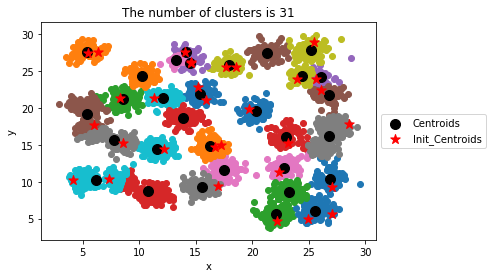

Text(0, 0.5, 'Cost')

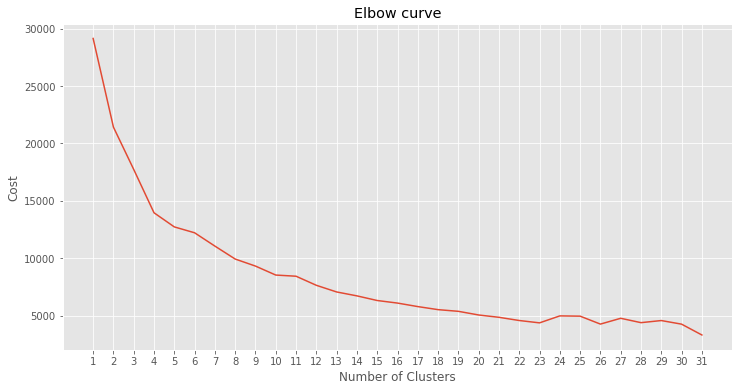

In [7]:
k_list = list(np.arange(1, 32))
costs = []
for i in k_list:
    costs.append(myKmeanPlusPlus(myk=i, myTol=0.0001, myMax=100))

# plot elbow curve to find optimized k
plt.style.use('ggplot')
plt.figure(figsize=(12,6))
plt.plot(k_list,costs)
plt.title("Elbow curve")
plt.xticks(k_list)
plt.xlabel("Number of Clusters")
plt.ylabel("Cost")

# 2. DBSCAN

In [8]:
"""Read input file named as ‘as3_2.csv’ using numpy. The file is composed of X and Y values in 
the first and second columns and label in the third column."""

df = pd.read_csv('https://raw.githubusercontent.com/atreish/AIM_5005_Machine_Learning/main/as3_2.csv', 
                   sep=',', names=['X','Y','label'])
df.head(5)

,X,Y,label
0,27.70,20.85,1
1,29.90,19.95,1
2,26.80,19.05,1
3,28.35,18.25,1
4,30.40,17.85,1


In [9]:
#How many classes are there? Summary Statistics of our Data frame
classes = df.label.unique()
X_col = df.X.describe()
Y_col = df.Y.describe()

print('The Summary Statistics of X Column are:\n\n{}'.format(X_col))
print('\n\nThe Summary Statistics of Y Column are:\n\n{}'.format(Y_col))
print('\n\nVector of Unique Class Variables:\n\n{}'.format(classes))

The Summary Statistics of X Column are:

count    396.000000
mean      22.160859
std        9.752082
min        7.150000
25%       14.062500
50%       18.950000
75%       32.800000
max       42.900000
Name: X, dtype: float64


The Summary Statistics of Y Column are:

count    396.000000
mean      13.911364
std        4.711783
min        5.750000
25%        9.750000
50%       14.000000
75%       18.100000
max       22.750000
Name: Y, dtype: float64


Vector of Unique Class Variables:

[1 2 3 4 5 6]


No handles with labels found to put in legend.


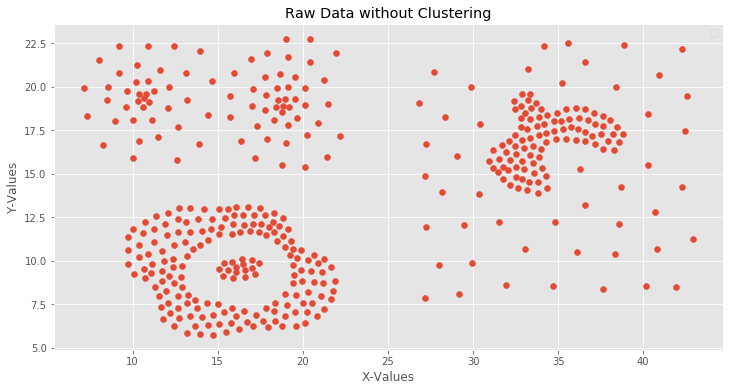

In [10]:
#Plot X,Y Data points

df1 = np.array(df.iloc[:,:-1]) 
plt.figure(figsize=(12,6))
plt.scatter(df1[:, 0], df1[:, 1])
plt.title('Raw Data without Clustering')
plt.xlabel('X-Values')
plt.ylabel('Y-Values')
plt.legend()
plt.show()

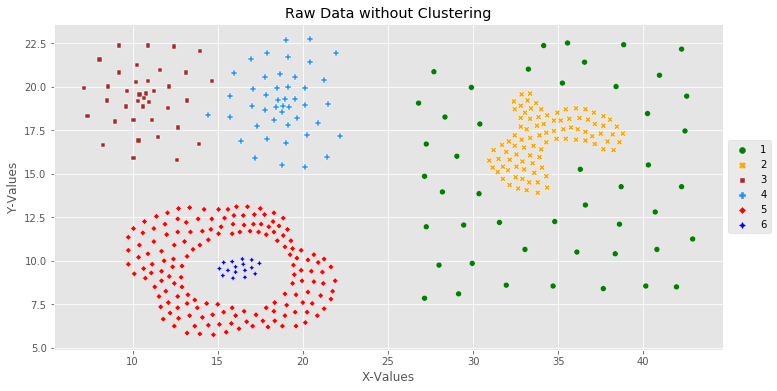

In [11]:
#Plot X,Y Data by Label using Seaborn hue

plt.figure(figsize=(12,6))
sns.scatterplot( data=df, x=df.X, y=df.Y, hue='label', style='label', 
                palette=['green','orange','brown','dodgerblue','red', 'blue'] ) 
plt.title('Raw Data without Clustering')
plt.xlabel('X-Values')
plt.ylabel('Y-Values')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

In [12]:
"""Create ‘getLabel()’ that receives true labels from the read file."""

def getLabel(df):
        return np.array(df.label)
    
"""Create ‘getDate()’ that returns vectors from the read file."""

def getData(df):
    return np.array(df.iloc[:, :-1])

#******************************************************************************************************
"""Create ‘getDBSCAN()’ that receives vectors, epsilon, and minPoints and
returns predicted label. This function finds the points in the epsilon 
neighborhood of every point, and identifies the core points with more than 
minPoints neighbors. Secondly, this function finds the connected components 
of core points on the neighbor graph. Lastly, this function assigns each 
non- core point to a nearby cluster if the cluster is an epsilon neighbor, 
otherwise assign it to noise."""

#Define variables to be use in the algorithm
vectors = getData(df)
noise = 0
unassigned_cluster = 0
core = -1
border = -2

def getDBSCAN(vectors, epsilon, minPoints):
   
    """Here we start by initializing a list of all 0 as noise/unassigned as 0, for ALL points. 
    The goal of this algorithm will be to reclassify points in this list to the appropriate class, 
    throughout we will reclassify according to theoritical criteria as 1 for cluster, -1 for core, 
    -2 for border point"""

    pred_label  = [unassigned_cluster] * len(vectors) 

    #initialize other lists
    point_neighbors = []
    corepoint = []
    noncore = []

    """ The following loop will look at all pairs i and j where i != j in our vectors array, and test their
    L2 norm and append the point_neighbors list. This is based on whether or not we are less than our input 
    parameter Episilon. It is important to note that all pairs i,j in vectors array have their OWN list of 
    neighbors based on L2 norm """
    
    for i in range(len(vectors)):
        points = []
        for j in range(len(vectors)):
            if np.linalg.norm(vectors[i] - vectors[j]) <= epsilon:
                points.append(j)
        point_neighbors.append(points)
     
    """ In the following code, we will look at the length of the point_neighbors vector. This vector
contains a certain amount of points in a 2D circle, if these points exceed our imput parameter 
MinPoints, then the point has a special relation to a CORE point. Think of it as a center of a 
cluster. The core point will be appended to the corepoint list, and non-core points will go to our
noncore list. Here we will also label ALL core points as -1, which is why we labels as - 1, as 
we have core=-1 above """
    
    
    for i in range(len(point_neighbors)):
        if (len(point_neighbors[i]) >= minPoints):
            pred_label[i] = core #label/classify the core point as -1
            corepoint.append(i)
        else:
            noncore.append(i)
   
    """Next, we will go through ALL values of ALL noncore points. We will try to determine if any of the 
appended noncore points are ALSO members in our corepoint array. This means that the point is noncore 
for some pair i,j but not sor i,k (for example). Such points we will label as border points. i.e. -2"""

    for i in noncore:
        for j in point_neighbors[i]:
            if j in corepoint:
                pred_label[i] = border #label/classify the border point as -2
                
                break
      
    """Here we will assign each point to a cluster using a Queue to group neighbor points and find their
neighbors"""

    clusters=1

    for i in range(len(pred_label)):
        q = queue.Queue()
        if (pred_label[i] == core):
            pred_label[i] = clusters #label/classify the core point as 1
            
            for x in point_neighbors[i]:
                # if the core point and neighbor point are all core point, put the neighbor point into queue
                # cluster neighbor point which is either another core point or a border point as same cluster as its core point
                if(pred_label[x] == core):
                    q.put(x)
                    pred_label[x] = clusters
                elif(pred_label[x]== border):
                    pred_label[x] = clusters
            #Stop when all point in Queue has been checked   
            while not q.empty():
                neighbors = point_neighbors[q.get()] 
                for y in neighbors:
                    if (pred_label[y]==core):
                        pred_label[y]=clusters
                        q.put(y)
                    if (pred_label[y]==border):
                        pred_label[y]=clusters            
            clusters = clusters+1 #move to next cluster
           
    return pred_label, clusters

#******************************************************************************************************

"""Create ‘getAccuracy()’ that receives predicted label and true label and returns accuracy."""

def getAccuracy(pred_label, true_label):
    pred_label = np.array(pred_label)+1
    correct = pred_label == true_label 
    return correct[correct==True].size /correct.size

"""Create ‘plotDBSCAN()’ that visualizes plot of clustering result in different colors and
makers. You can use any plot method."""

def plotDBSCAN(vector, clusterRes, clusterNum):
    nPoints = len(vector)
    for i in range(clusterNum):
        x1 = []
        y1 = []
        for j in range(nPoints):
            if clusterRes[j] == i:
                x1.append(vector[j, 0])
                y1.append(vector[j, 1])
        
        plt.scatter(x1, y1, alpha=1, marker='.', label="Predicted Label={}".format(i+1))
        plt.title('DBSCAN Predicted Label Results')
        plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    

# Selection of Hyperparameters for DBSCAN algorithm, Epsilon and MinPoints

In [13]:
hyperparameters = np.asarray([(x,y) for x in np.arange(0.1,2,0.1) for y in range(2,10)])
real_labels = getLabel(df)
scores_ = {}

for (i,j) in hyperparameters[:]:
    pred, cluster_number = getDBSCAN(vectors,i,j)
    pred_score = getAccuracy(pred, real_labels)
    scores_[pred_score] = (i,j)

print('The Maximum CV Score is {}, parameters are Episilon, MinPoints= {}'.format(max(scores_),scores_[max(scores_)]))

The Maximum CV Score is 0.9696969696969697, parameters are Episilon, MinPoints= (1.5000000000000002, 5.0)


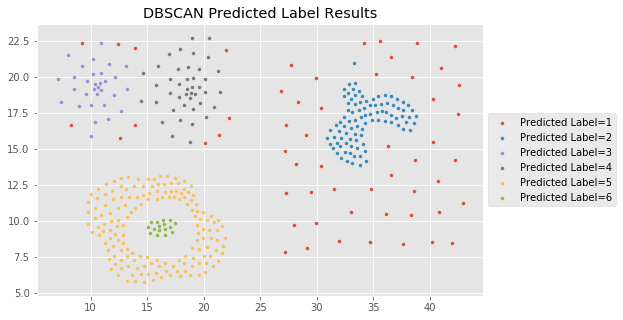

Accuracy of DBSCAN Algorithm is = 0.9697  


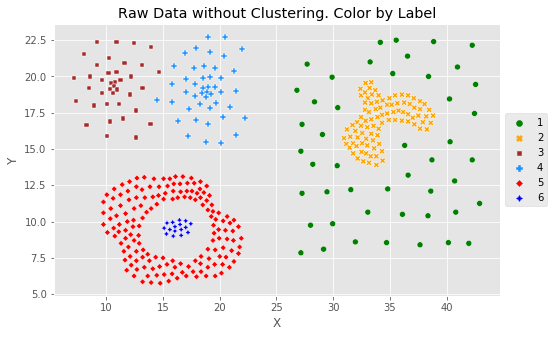

In [14]:
#Plotting our dataframe after applying 

vectors = getData(df)
epsilon = 1.5
minPoints = 5  
pred_label, clusters = getDBSCAN(vectors,epsilon,minPoints)
plt.figure(figsize=(8,5))
plotDBSCAN(vectors, pred_label, clusters)
plt.show()
score = getAccuracy(pred_label, getLabel(df))
print('Accuracy of DBSCAN Algorithm is = %.4f  ' % score)

#Let us compare with original graphic by shaded hue by Label in Seaborn

plt.figure(figsize=(8,5))
sns.scatterplot(data=df, x=df.X, y=df.Y, hue='label', style='label', 
                palette=['green','orange','brown','dodgerblue','red', 'blue'] )
plt.title('Raw Data without Clustering. Color by Label')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()


# 3. Improved DBSCAN

`Implement improved DBSCAN method using one of existing algorithms introduced in the paper “S. Li, An Improved DBSCAN Algorithm Based on the Neighbor Similarity and Fast Nearest Neighbor Query, IEEE Access, 2020”. 

This paper introduces many previous methods enhancing performance and accuracy. You can use any suggested methods in Section II, RELATED WORK as well as the method that the paper mainly suggests. 

Show the enhanced accuracy comparing to what you will be obtaining in the previous problem 2 (DBSCAN). You can use the same functions that you have implemented and dataset in problem 2. You can use different dataset from problem 2 to show better accuracy but when you compare the accuracy, the chosen dataset should be equally and additionally used in problem 2.`

In [15]:
def getILabel(df):
        return np.array(df.label)
    
def getIData(df):
    return np.array(df.iloc[:, :-1])

#Define variables to be use in the algorithm
vectors = getIData(df)
noise = 0
unassigned_cluster = 0
core = -1
border = -2

def ImprovedDBSCAN(vectors, epsilon, minPoints):
    pred_label  = [unassigned_cluster] * len(vectors) 
    point_neighbors = []
    corepoint = []
    noncore = []

    """Here we will use the suggested KDTree clustering to determine clusters of points and whether
    they are neighbors of length epsilon or not from each point in vector[i]"""
  
    kd = spatial.KDTree(vectors)
    for i in range(len(vectors)):
        points = kd.query_ball_point(vectors[i], epsilon)
        point_neighbors.append(points)
        
    for i in range(len(point_neighbors)):
        if (len(point_neighbors[i]) >= minPoints):
            pred_label[i] = core #label/classify the core point as -1
            corepoint.append(i)
        else:
            noncore.append(i)
   
    for i in noncore:
        for j in point_neighbors[i]:
            if j in corepoint:
                pred_label[i] = border 
                
                break

    clusters=1

    for i in range(len(pred_label)):
        q = queue.Queue()
        if (pred_label[i] == core):
            pred_label[i] = clusters
            
            for x in point_neighbors[i]:
                
                if(pred_label[x] == core):
                    q.put(x)
                    pred_label[x] = clusters
                elif(pred_label[x]== border):
                    pred_label[x] = clusters
                    
            while not q.empty():
                neighbors = point_neighbors[q.get()] 
                for y in neighbors:
                    if (pred_label[y]==core):
                        pred_label[y]=clusters
                        q.put(y)
                    if (pred_label[y]==border):
                        pred_label[y]=clusters            
            clusters=clusters+1 #move to next cluster
           
    return pred_label, clusters

def getimprovedaccuracy(pred_label, true_label):
    pred_label = np.array(pred_label)+1
    correct = pred_label == true_label 
    return correct[correct==True].size /correct.size

def plotIDBSCAN(vector, clusterRes, clusterNum):
    nPoints = len(vector)
    for i in range(clusterNum):
        x1 = []
        y1 = []
        for j in range(nPoints):
            if clusterRes[j] == i:
                x1.append(vector[j, 0])
                y1.append(vector[j, 1])
        
        plt.scatter(x1, y1, alpha=1, marker='.', label="Predicted Label={}".format(i+1))
        plt.title('Improved DBSCAN Predicted Label Results')
        plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

# Comparision between DBSCAN and Improved DBSCAN

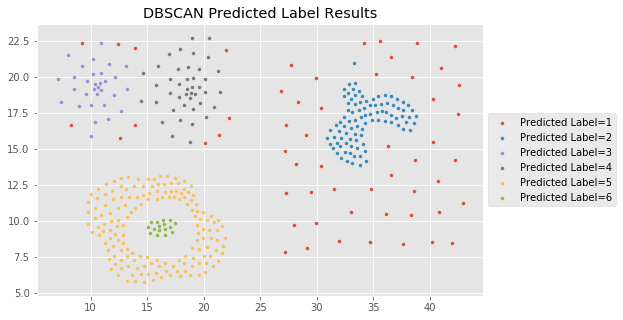

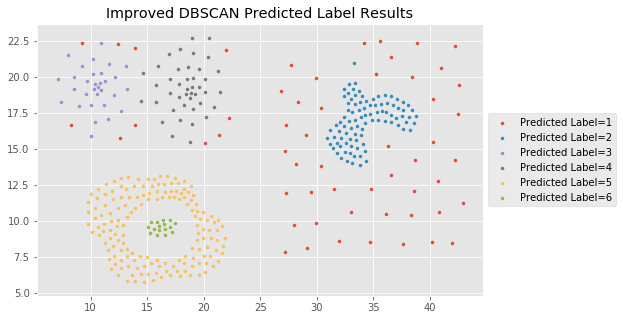

Accuracy of original DBSCAN Algorithm is = 0.9697 
Original DBSCAN time for computation is 1.6326580047607422 seconds

vs

Accuracy of Improved DBSCAN Algorithm is = 0.9697 
Improved DBSCAN time for computation is 0.47213006019592285 seconds


There is a computation time improvement of 1.1605279445648193 seconds
**************************************************************************************************


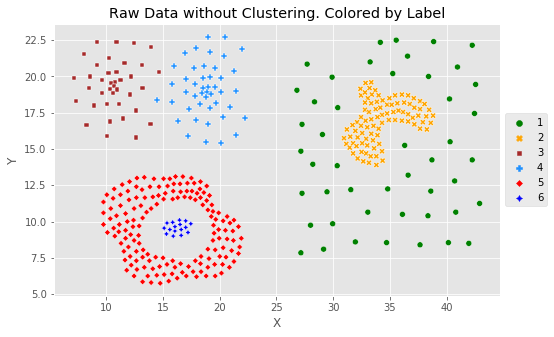

In [16]:
vectors1 = getData(df)
epsilon1 = 1.5
minPoints1 = 5
start = time.time()
pred_label1, clusters1 = getDBSCAN(vectors1,epsilon1,minPoints1)
end = time.time()
plt.figure(figsize=(8,5))
plotDBSCAN(vectors1, pred_label1, clusters1)
plt.show()
score1 = getAccuracy(pred_label1, getLabel(df))

vectors = getIData(df)
epsilon = 1.5
minPoints = 5 
start1 = time.time()
pred_label, clusters = ImprovedDBSCAN(vectors,epsilon,minPoints)
end1 = time.time()
plt.figure(figsize=(8,5))
plotIDBSCAN(vectors, pred_label, clusters)
plt.show()
imp_score = getimprovedaccuracy(pred_label, getILabel(df))

dbscan_time = end-start
idbscan_time = end1-start1
time_diff = dbscan_time - idbscan_time
time_diff

print('Accuracy of original DBSCAN Algorithm is = %.4f ' % score1)
print(f'Original DBSCAN time for computation is {end-start} seconds')
print('\nvs')
print('\nAccuracy of Improved DBSCAN Algorithm is = %.4f ' % imp_score)
print(f'Improved DBSCAN time for computation is {end1-start1} seconds')
print('\n')
print('There is a computation time improvement of {} seconds'.format(time_diff))
print('**************************************************************************************************')
plt.figure(figsize=(8,5))
sns.scatterplot(data=df, x=df.X, y=df.Y, hue='label', style='label', 
                palette=['green','orange','brown','dodgerblue','red', 'blue'] )
plt.title('Raw Data without Clustering. Colored by Label')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

In [17]:
#Boolean list of label comparisons
a = np.array(pred_label)+1
b = getLabel(df)
c = np.in1d(a,b)
c

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,

## Reference

`Paper of K-means++ Algorithm`  http://ilpubs.stanford.edu:8090/778/1/2006-13.pdf

`Wikipedia Article on KMEANS ++` https://en.wikipedia.org/wiki/DBSCAN

`DBSCAN Algorithm` https://towardsdatascience.com/understanding-dbscan-algorithm-and-implementation-from-scratch-c256289479c5

`“S. Li, An Improved DBSCAN Algorithm Based on the Neighbor Similarity and Fast Nearest Neighbor Query, IEEE Access, 2020”`